In [34]:
DATA_PATH = '../Data/Raw/'
PKL_EXPORT_PATH = "../data/processed/0_DataCleaned_all_df.pkl"
CSV_EXPORT_PATH = "../data/processed/0_DataCleaned_all_df.csv"
US_STATES_ABBR = '../Data/Raw/us_states.xlsx'

In [3]:
# Packages to import
import pandas as pd 
import numpy as np
import re
import logging
import pickle
import glob
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [3]:
# Get CSV files list from a folder
csv_files = glob.glob(DATA_PATH + "/raw_*")
# load the dataframes and concatenate them
raw_df = pd.concat(map(pd.read_csv, csv_files))
raw_df = raw_df.set_index('Unnamed: 0').reset_index(drop=True)
raw_df.shape

(8000, 12)

In [4]:
raw_df

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue
0,Data Analyst,Employer Provided Salary:$102K - $148K,"At Realtor.com®, we have among the most compre...",3.7,Realtor.com Careers\n3.7,"Austin, TX",1001 to 5000 Employees,1993,Company - Private,Computer Hardware Development,Information Technology,Unknown / Non-Applicable
1,Data Analyst,-1,Greetings\nI am seeking for technical consulta...,-1.0,SMK Soft Inc,Remote,-1,-1,-1,-1,-1,-1
2,Data Analyst,$54K - $82K (Glassdoor est.),"This is an in-office position, working out of ...",4.5,Visionary Homes\n4.5,"North Logan, UT",51 to 200 Employees,2004,Company - Private,Construction,"Construction, Repair & Maintenance Services",Unknown / Non-Applicable
3,Data Mining Analyst,$63K - $91K (Glassdoor est.),Kodak Alaris is a global technology company th...,4.0,Kodak Alaris\n4.0,"Rochester, NY",1001 to 5000 Employees,2013,Company - Private,Information Technology Support Services,Information Technology,$500 million to $1 billion (USD)
4,Data Analyst,Employer Provided Salary:$40.00 - $45.00 Per Hour,Primary Duties: Data Analyst 2\nProvide ad-hoc...,3.9,GSK Solutions Inc\n3.9,"Richmond, VA",1 to 50 Employees,2010,Company - Private,Business Consulting,Management & Consulting,$5 to $25 million (USD)
...,...,...,...,...,...,...,...,...,...,...,...,...
7995,Machine Learning Scientist I,$95K - $136K (Glassdoor est.),Machine Learning Scientist I\nFlexible within ...,3.5,Cambia Health Solutions\n3.5,"Portland, OR",5001 to 10000 Employees,1917,Nonprofit Organization,Health Care Services & Hospitals,Healthcare,Unknown / Non-Applicable
7996,"Data Scientist(RNAseq,Genomics,Omnics,Machine ...",Employer Provided Salary:$51.00 - $52.00 Per Hour,Job Description:\nResponsibilities:\nProject i...,3.7,Tellus Solutions\n3.7,Remote,51 to 200 Employees,2006,Company - Private,Information Technology Support Services,Information Technology,$5 to $25 million (USD)
7997,Machine Learning Research Scientist - Natural ...,Employer Provided Salary:$152K - $210K,"At Toyota Research Institute (TRI), we’re on a...",4.1,Toyota Research Institute\n4.1,"Los Altos, CA",201 to 500 Employees,2016,Subsidiary or Business Segment,Research & Development,Management & Consulting,Unknown / Non-Applicable
7998,Sr Applied Machine Learning Scientist,Employer Provided Salary:$128K - $196K,About Grainger\nGrainger is a global leading b...,4.1,Grainger\n4.1,"Chicago, IL",10000+ Employees,1927,Company - Public,Wholesale,Retail & Wholesale,$10+ billion (USD)


In [5]:
# Display random answer
raw_df.sample(1).iloc[0]

Job Title                                        Data Engineer - LATAM
Salary Estimate                                                     -1
Job Description      About Passport:\n\nPassport is reinventing cro...
Rating                                                             2.7
Company Name                                             Passport\n2.7
Location                                                        Remote
Size                                              201 to 500 Employees
Founded                                                           2010
Type of ownership                                    Company - Private
Industry                                 Computer Hardware Development
Sector                                          Information Technology
Revenue                                        $5 to $25 million (USD)
Name: 3399, dtype: object

In [6]:
raw_df.sample()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue
1028,Data Analyst,$59K - $86K (Glassdoor est.),"Data Analyst\nLocation: Atlanta, GA, 30328\nWe...",-1.0,Healthlink Dimensions,"Atlanta, GA",1 to 50 Employees,2001,Company - Private,-1,-1,$5 to $25 million (USD)


In [7]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          8000 non-null   object 
 1   Salary Estimate    8000 non-null   object 
 2   Job Description    8000 non-null   object 
 3   Rating             8000 non-null   float64
 4   Company Name       8000 non-null   object 
 5   Location           7998 non-null   object 
 6   Size               8000 non-null   object 
 7   Founded            8000 non-null   int64  
 8   Type of ownership  8000 non-null   object 
 9   Industry           8000 non-null   object 
 10  Sector             8000 non-null   object 
 11  Revenue            8000 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 750.1+ KB


# Data Cleaning & preprocessing
__________________________________________________________________________________________________________________________________________________


## 2. Salary Column

### 1. Parse the Salary Data Column 
### 2. Remove rows in which salary equal -1
### 3. Remove any Text in the columns
### 4. Change Hourly Rate salary to Yearly rate
### 5. split salary into min and max salary column
### 6. calculate the avg salary

In [8]:
# How many Null values in the salary column
len(raw_df[raw_df['Salary Estimate' ] == '-1'])

2010

In [9]:
# Remove Columns where Salary == -1, We Ended up with 778 rows that have salary
raw_df = raw_df[raw_df['Salary Estimate'] != '-1']
len(raw_df)

5990

In [5]:
raw_df['Salary Estimate'].sample(20)

4111                Employer Provided Salary:$93K - $103K
2013               Employer Provided Salary:$134K - $194K
5285                Employer Provided Salary:$89K - $120K
2590                        $76K - $108K (Glassdoor est.)
3414               Employer Provided Salary:$150K - $175K
1415                 Employer Provided Salary:$65K - $80K
4281               Employer Provided Salary:$140K - $178K
2963                        $89K - $128K (Glassdoor est.)
2717                       $107K - $149K (Glassdoor est.)
5240                        $95K - $136K (Glassdoor est.)
3904               Employer Provided Salary:$110K - $196K
2108               Employer Provided Salary:$134K - $194K
2602                        $70K - $106K (Glassdoor est.)
325     Employer Provided Salary:$30.00 - $35.00 Per Hour
3220                        $89K - $128K (Glassdoor est.)
1871                        $71K - $101K (Glassdoor est.)
809                          $50K - $70K (Glassdoor est.)
2143    Employ

In [13]:
# Use Regex to Remove Text in the Salary Column
salary = raw_df['Salary Estimate'].str.replace(r'[^0-9-_]', '',regex = True)
salary.sample(10)

3863      160-247
254         64-85
5592      126-222
102       130-196
2173    6000-8000
671            53
4921      140-178
1077        65-80
24          75-90
625       102-148
Name: Salary Estimate, dtype: object

In [14]:
# The Per hour Columns salary became so big after the dot removed
print(salary.loc[325])
print(salary.loc[2143])
print(salary.loc[15])

3000-3500
6000-7000
2475-2850


In [15]:
# split the salary column into a list 
list_salary =salary.str.split('-')

In [16]:
# We need to change the per hour salary to per year
# per year rate = no. * 1.8 / 1000
#Loop through the salary list and check for numbers > 1000 (per hour columns) and divide by 100
for s in list_salary:
    for i in range(len(s)):
        if int(s[i]) >= 1000:
            s[i] = (int(s[i]) * 1.8)/ 100

In [17]:
print(list_salary.loc[2143])
print(list_salary.loc[325])
print(list_salary.loc[15])

[108.0, 126.0]
[54.0, 63.0]
[44.55, 51.3]


In [18]:
raw_df = raw_df.copy()
# Create Two new columns( one for min_salary and one for max_salary)
raw_df['min_salary'] = list_salary.apply(lambda x: int(x[0]))
# Takes x[0] if list has only one value,
raw_df['max_salary'] = list_salary.apply(lambda x: int(x[1]) if len(x)>1 else int(x[0]))

In [19]:
list_salary

0           [54, 82]
1           [63, 91]
2       [72.0, 81.0]
3           [65, 85]
4               [99]
            ...     
5658       [95, 136]
5659    [91.8, 93.6]
5660      [152, 210]
5661      [128, 196]
5662      [160, 226]
Name: Salary Estimate, Length: 5663, dtype: object

In [20]:
pd.reset_option('mode.chained_assignment')
with pd.option_context('mode.chained_assignment', None):# Evaluate the avg salary
    raw_df['avg_salary'] = (raw_df.min_salary + raw_df.max_salary) / 2

In [19]:
raw_df

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue,min_salary,max_salary,avg_salary
0,Data Analyst,Employer Provided Salary:$102K - $148K,"At Realtor.com®, we have among the most compre...",3.7,Realtor.com Careers\n3.7,"Austin, TX",1001 to 5000 Employees,1993,Company - Private,Computer Hardware Development,Information Technology,Unknown / Non-Applicable,102,148,125.0
2,Data Analyst,$54K - $82K (Glassdoor est.),"This is an in-office position, working out of ...",4.5,Visionary Homes\n4.5,"North Logan, UT",51 to 200 Employees,2004,Company - Private,Construction,"Construction, Repair & Maintenance Services",Unknown / Non-Applicable,54,82,68.0
3,Data Mining Analyst,$63K - $91K (Glassdoor est.),Kodak Alaris is a global technology company th...,4.0,Kodak Alaris\n4.0,"Rochester, NY",1001 to 5000 Employees,2013,Company - Private,Information Technology Support Services,Information Technology,$500 million to $1 billion (USD),63,91,77.0
4,Data Analyst,Employer Provided Salary:$40.00 - $45.00 Per Hour,Primary Duties: Data Analyst 2\nProvide ad-hoc...,3.9,GSK Solutions Inc\n3.9,"Richmond, VA",1 to 50 Employees,2010,Company - Private,Business Consulting,Management & Consulting,$5 to $25 million (USD),72,81,76.5
5,Data Analyst,Employer Provided Salary:$65K - $85K," Responsible for the design, development and ...",2.0,Cognize Tech Solutions\n2.0,Remote,51 to 200 Employees,-1,Company - Private,-1,-1,Unknown / Non-Applicable,65,85,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,Machine Learning Scientist I,$95K - $136K (Glassdoor est.),Machine Learning Scientist I\nFlexible within ...,3.5,Cambia Health Solutions\n3.5,"Portland, OR",5001 to 10000 Employees,1917,Nonprofit Organization,Health Care Services & Hospitals,Healthcare,Unknown / Non-Applicable,95,136,115.5
7996,"Data Scientist(RNAseq,Genomics,Omnics,Machine ...",Employer Provided Salary:$51.00 - $52.00 Per Hour,Job Description:\nResponsibilities:\nProject i...,3.7,Tellus Solutions\n3.7,Remote,51 to 200 Employees,2006,Company - Private,Information Technology Support Services,Information Technology,$5 to $25 million (USD),91,93,92.0
7997,Machine Learning Research Scientist - Natural ...,Employer Provided Salary:$152K - $210K,"At Toyota Research Institute (TRI), we’re on a...",4.1,Toyota Research Institute\n4.1,"Los Altos, CA",201 to 500 Employees,2016,Subsidiary or Business Segment,Research & Development,Management & Consulting,Unknown / Non-Applicable,152,210,181.0
7998,Sr Applied Machine Learning Scientist,Employer Provided Salary:$128K - $196K,About Grainger\nGrainger is a global leading b...,4.1,Grainger\n4.1,"Chicago, IL",10000+ Employees,1927,Company - Public,Wholesale,Retail & Wholesale,$10+ billion (USD),128,196,162.0


## 1. Job title Column

### 1. Try to classify the job titles in terms of title and seniority
### 2. the seniority column has alot of missing values

In [20]:
raw_df['Job Title'].value_counts().head(60)

Data Analyst                                                              609
Data Engineer                                                             445
Data Scientist                                                            439
Machine Learning Engineer                                                 212
Decision Scientist                                                        146
Senior Data Engineer                                                      113
Senior Data Scientist                                                      82
Staff Data Scientist                                                       79
Junior Data Engineer                                                       75
Data Analytics Engineer                                                    65
Machine Learning Engineer II                                               56
Associate Data & Decision Scientist                                        52
Data Analyst I                                                  

In [21]:
def title_simplifier(title):
    if 'data scientist' in title.lower() or 'data science' in title.lower():
        return 'data scientist'
    elif 'data analyst' in title.lower() or 'analyst' in title.lower():
        return 'data analyst'
    elif 'decision scientist' in title.lower():
        return 'decision scientist'
    elif 'artificial intelligence' in title.lower() or 'machine learning' in title.lower() or 'nlp engineer' in title.lower():
        return 'machine learning engineer'
    elif 'deep learning' in title.lower() or 'ml' in title.lower() or 'ai' in title.lower():
        return 'machine learning engineer'
    elif 'data engineer' in title.lower():
        return 'data engineer'
    elif 'quantitative researcher' in title.lower():
        return 'quantitative researcher'
    elif 'data partnerships lead' in title.lower():
        return 'data partnerships lead'
    elif 'scientist' in title.lower():
        return 'data scientist'
    elif 'engineer' in title.lower():
        return'data engineer'
    else:
        return 'na'
    
def seniorty(title):
    if 'senior' in title.lower() or 'sr' in title.lower() or 'lead' in title.lower() or 'principal' in title.lower():
        return 'senior'
    elif 'jr' in title.lower() or 'jr.' in title.lower() or 'junior' in title.lower():
        return 'junior'
    else:
        return 'na'

In [22]:
raw_df['job_title'] = raw_df['Job Title'].apply(title_simplifier)

In [23]:
raw_df.job_title.value_counts()

data analyst                 1554
data scientist               1541
data engineer                1426
machine learning engineer    1213
decision scientist            198
data partnerships lead         30
na                             26
quantitative researcher         2
Name: job_title, dtype: int64

In [24]:
raw_df.loc[raw_df['job_title'] == 'na','Job Title'].value_counts()

Software Support Representative                  8
Personalized Internet Assessor (US)              5
SDE - Amazon Robotics, Robotic                   5
Junior BA                                        1
DevSecOps                                        1
Small Business Loan Collector                    1
Operations/HR Assistant                          1
Remote Customer Service Representative           1
Mathematician                                    1
VP, Data Intelligence                            1
People Service Intake and Transformation Lead    1
Name: Job Title, dtype: int64

In [25]:
raw_df = raw_df.loc[raw_df['job_title'] != 'na']

In [26]:
raw_df= raw_df.copy()
raw_df['seniority'] = raw_df['Job Title'].apply(seniorty)

In [27]:
# alot of Na in the seniority column
raw_df['seniority'].value_counts()

na        4875
senior     725
junior     364
Name: seniority, dtype: int64

## 3. Description Column

### 1. Create a new column call Desc_length, contain no. of characters in each job description

In [28]:
raw_df['Job Description'][0]

'At Realtor.com®, we have among the most comprehensive and accurate coverage of real estate listings and the most engaged users across all the online real estate portals. Our mission is to make buying, selling, renting, and living in homes easier and more rewarding for everyone.\nBuilding your career? Build it better at Realtor.com®. Join us and help change the world of real estate, one home at a time.\nWe have the most comprehensive and accurate coverage of real estate listings and the most engaged users across all the online real estate portals. Our mission is to make buying, selling, renting, and living in homes more effortless and rewarding for everyone.\nThe Data Analytics team at Realtor.com sits at the heart of this mission. We process and analyze terabytes of data every day that enable decisions for millions of home buyers, sellers, renters, dreamers, and real estate professionals. Our goal is to use this data to make the home-buying experience a breeze for our consumers. We em

In [29]:
raw_df['desc_len'] = raw_df['Job Description'].apply(lambda x: len(x))
raw_df['desc_len']

0       1206
2        914
3       2071
4        593
5        901
        ... 
7995    7095
7996     882
7997    4785
7998    4682
7999    8576
Name: desc_len, Length: 5964, dtype: int64

<Axes: >

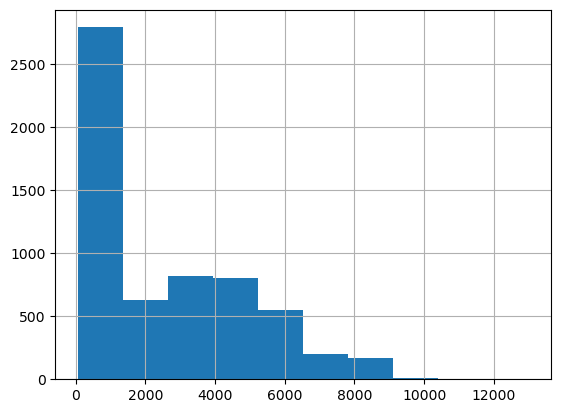

In [30]:
raw_df['desc_len'].hist()

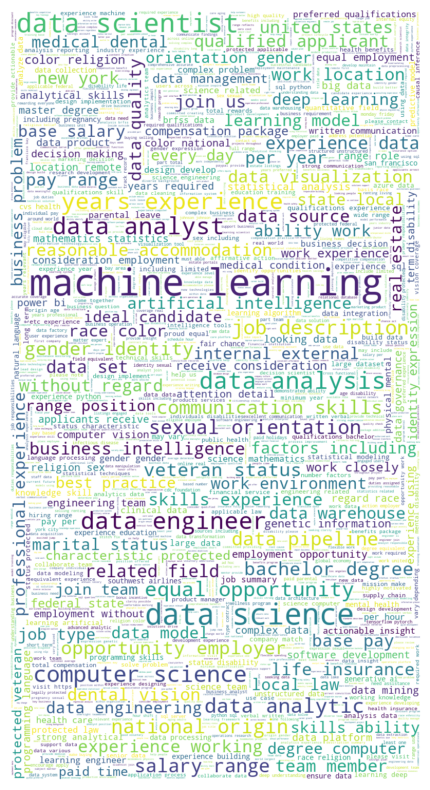

In [34]:
words = " ".join(raw_df['Job Description'])

def punctuation_stop(text):
    """remove punctuation and stop words"""
    filtered = []
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    for w in word_tokens:
        if w not in stop_words and w.isalpha():
            filtered.append(w.lower())
    return filtered


words_filtered = punctuation_stop(words)

text = " ".join([ele for ele in words_filtered])

wc= WordCloud(background_color="white", random_state=1,stopwords=STOPWORDS, max_words = 2000, width =800, height = 1500)
wc.generate(text)

plt.figure(figsize=[10,10])
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')
plt.show()

In [96]:
words_count= {}
for word in words_filtered:
    words_count[word] = words_count.get(word,0) +1
tools = ['python', 'r', 'aws', 'azure','hadoop','spark','excel''statistics','sql', 'azure','tensor','pytorch','keras', 'scikit-learn']
techs = ['nlp','llm','visualization','mining','cloud','ml','ai','machine', 'deep','chatgpt','neural','etl','warehousing','insights','research']
education =['phd','doctorate','master','msc','bsc','bachelor']
for tool in tools:
    if tool in words_count:
        print(f'{tool} : {words_count[tool]}')

python : 3093
r : 1322
aws : 1395
azure : 969
hadoop : 378
spark : 494
sql : 3358
azure : 969
pytorch : 340
keras : 267


In [99]:
count = []
for row in range(len(raw_df)):
    sum = 0
    for tool in tools:
        if tool in raw_df.iloc[row,2]:
            sum +=1
    count.append(sum)
raw_df['tools'] = count

In [102]:
count = []
for row in range(len(raw_df)):
    sum = 0
    for tech in techs:
        if tool in raw_df.iloc[row,2]:
            sum +=1
    count.append(sum)
raw_df['techs'] = count

In [103]:
count = []
for row in range(len(raw_df)):
    sum = 0
    for edu in education:
        if tool in raw_df.iloc[row,2]:
            sum +=1
    count.append(sum)
raw_df['education'] = count

In [104]:
raw_df

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,...,Revenue,min_salary,max_salary,avg_salary,job_title,seniority,desc_len,tools,techs,education
0,Data Analyst,Employer Provided Salary:$102K - $148K,"At Realtor.com®, we have among the most compre...",3.7,Realtor.com Careers\n3.7,"Austin, TX",1001 to 5000 Employees,1993,Company - Private,Computer Hardware Development,...,Unknown / Non-Applicable,102,148,125.0,data analyst,na,1206,1,0,0
2,Data Analyst,$54K - $82K (Glassdoor est.),"This is an in-office position, working out of ...",4.5,Visionary Homes\n4.5,"North Logan, UT",51 to 200 Employees,2004,Company - Private,Construction,...,Unknown / Non-Applicable,54,82,68.0,data analyst,na,914,1,0,0
3,Data Mining Analyst,$63K - $91K (Glassdoor est.),Kodak Alaris is a global technology company th...,4.0,Kodak Alaris\n4.0,"Rochester, NY",1001 to 5000 Employees,2013,Company - Private,Information Technology Support Services,...,$500 million to $1 billion (USD),63,91,77.0,data analyst,na,2071,2,0,0
4,Data Analyst,Employer Provided Salary:$40.00 - $45.00 Per Hour,Primary Duties: Data Analyst 2\nProvide ad-hoc...,3.9,GSK Solutions Inc\n3.9,"Richmond, VA",1 to 50 Employees,2010,Company - Private,Business Consulting,...,$5 to $25 million (USD),72,81,76.5,data analyst,na,593,1,0,0
5,Data Analyst,Employer Provided Salary:$65K - $85K," Responsible for the design, development and ...",2.0,Cognize Tech Solutions\n2.0,Remote,51 to 200 Employees,-1,Company - Private,-1,...,Unknown / Non-Applicable,65,85,75.0,data analyst,na,901,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,Machine Learning Scientist I,$95K - $136K (Glassdoor est.),Machine Learning Scientist I\nFlexible within ...,3.5,Cambia Health Solutions\n3.5,"Portland, OR",5001 to 10000 Employees,1917,Nonprofit Organization,Health Care Services & Hospitals,...,Unknown / Non-Applicable,95,136,115.5,machine learning engineer,na,7095,3,15,6
7996,"Data Scientist(RNAseq,Genomics,Omnics,Machine ...",Employer Provided Salary:$51.00 - $52.00 Per Hour,Job Description:\nResponsibilities:\nProject i...,3.7,Tellus Solutions\n3.7,Remote,51 to 200 Employees,2006,Company - Private,Information Technology Support Services,...,$5 to $25 million (USD),91,93,92.0,data scientist,na,882,1,0,0
7997,Machine Learning Research Scientist - Natural ...,Employer Provided Salary:$152K - $210K,"At Toyota Research Institute (TRI), we’re on a...",4.1,Toyota Research Institute\n4.1,"Los Altos, CA",201 to 500 Employees,2016,Subsidiary or Business Segment,Research & Development,...,Unknown / Non-Applicable,152,210,181.0,machine learning engineer,na,4785,3,0,0
7998,Sr Applied Machine Learning Scientist,Employer Provided Salary:$128K - $196K,About Grainger\nGrainger is a global leading b...,4.1,Grainger\n4.1,"Chicago, IL",10000+ Employees,1927,Company - Public,Wholesale,...,$10+ billion (USD),128,196,162.0,machine learning engineer,senior,4682,1,0,0



## 5. Company Name Column

### 1. Remove the trailing Rating from the company name
### 2. remove the \n from the company name

In [105]:
# you can see that companies that has -1 Rating, there name is fine
# but companies that has a Rating, there name ends with "\n3.2"
raw_df[['Rating','Company Name']].sample(40)

,Rating,Company Name
6505,4.4,Adobe\n4.4
4257,3.9,UT Southwestern\n3.9
3518,-1.0,Zoomph
7801,5.0,Runway AI\n5.0
17,4.3,CT Solutions\n4.3
1232,3.2,ITR Concession Co LLC\n3.2
802,4.3,CT Solutions\n4.3
2794,3.7,GoodLeap\n3.7
5042,-1.0,Synapseb systems
753,4.5,Visionary Homes\n4.5


In [106]:
# Remove the Rating and /n from the company name tail
raw_df['company_name'] = raw_df['Company Name'].str.replace(r'\n([0-9]\.[0-9])','',regex = True)
raw_df['company_name'] = raw_df['company_name'].str.replace(r'\r','',regex = True)

In [108]:
len(raw_df['company_name'].unique())
raw_df['company_name'].value_counts().head(60)

Meta                                                            152
Realtor.com Careers                                             128
Honor                                                            93
PayPal                                                           83
Disney                                                           82
AI Labs at the American Alliance for International Education     72
Microsoft                                                        69
Southwest Airlines                                               67
Mastercard                                                       63
Salesforce                                                       62
Runway AI                                                        61
Grainger                                                         61
Visionary Homes                                                  56
NVIDIA                                                           56
Prime Therapeutics                              

## 4. Rating Column

In [109]:
raw_df['Rating'].value_counts()

 3.9    814
-1.0    709
 4.1    521
 4.0    377
 3.7    366
 4.2    319
 4.3    317
 5.0    286
 3.8    262
 3.2    261
 3.6    231
 3.5    217
 3.4    184
 4.6    157
 4.4    148
 3.1    135
 4.5    126
 3.3     91
 3.0     76
 4.7     67
 4.9     66
 4.8     63
 2.7     61
 2.0     48
 2.9     31
 2.8     15
 2.6      6
 2.4      4
 1.0      4
 2.3      2
Name: Rating, dtype: int64

In [110]:
raw_df.loc[raw_df['Rating'] == -1, 'company_name'].value_counts()

AI Labs at the American Alliance for International Education    72
Juji                                                            49
Konnectingtree                                                  33
Data Annotation                                                 29
PROC9                                                           29
                                                                ..
Cilable                                                          1
Slesha inc                                                       1
Celerens                                                         1
Trail Blazer                                                     1
MDACCESS                                                         1
Name: company_name, Length: 97, dtype: int64

In [111]:
raw_df.loc[raw_df['company_name'] == 'Juji', 'Rating'] = 4.0

In [112]:
raw_df.loc[raw_df['company_name'] == 'Konnectingtree', 'Rating'] = 4.4

In [113]:
raw_df.loc[raw_df['company_name'] == 'AI Labs at the American Alliance for International Education']

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,...,min_salary,max_salary,avg_salary,job_title,seniority,desc_len,tools,techs,education,company_name
6005,Research Scientist: Machine Learning & AI (Rem...,Employer Provided Salary:$70.00 - $120.00 Per ...,This is a part-time and remote job for Researc...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,126,216,171.0,machine learning engineer,na,947,1,0,0,AI Labs at the American Alliance for Internati...
6013,Principal Machine Learning Engineers (Remote/P...,Employer Provided Salary:$65.00 - $120.00 Per ...,This is a part-time and remote job for Princip...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,117,216,166.5,machine learning engineer,senior,910,1,0,0,AI Labs at the American Alliance for Internati...
6235,Research Scientist: Machine Learning & AI (Rem...,Employer Provided Salary:$70.00 - $120.00 Per ...,This is a part-time and remote job for Researc...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,126,216,171.0,machine learning engineer,na,947,1,0,0,AI Labs at the American Alliance for Internati...
6265,Research Scientist: Machine Learning & AI (Rem...,Employer Provided Salary:$70.00 - $120.00 Per ...,This is a part-time and remote job for Researc...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,126,216,171.0,machine learning engineer,na,947,1,0,0,AI Labs at the American Alliance for Internati...
6291,Research Scientist: Machine Learning & AI (Rem...,Employer Provided Salary:$70.00 - $120.00 Per ...,This is a part-time and remote job for Researc...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,126,216,171.0,machine learning engineer,na,947,1,0,0,AI Labs at the American Alliance for Internati...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7920,Research Scientist: Machine Learning & AI (Rem...,Employer Provided Salary:$70.00 - $120.00 Per ...,This is a part-time and remote job for Researc...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,126,216,171.0,machine learning engineer,na,2764,2,15,6,AI Labs at the American Alliance for Internati...
7944,Principal Machine Learning Engineers (Remote/P...,Employer Provided Salary:$65.00 - $120.00 Per ...,This is a part-time and remote job for Princip...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,117,216,166.5,machine learning engineer,senior,2600,2,15,6,AI Labs at the American Alliance for Internati...
7950,Research Scientist: Machine Learning & AI (Rem...,Employer Provided Salary:$70.00 - $120.00 Per ...,This is a part-time and remote job for Researc...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,126,216,171.0,machine learning engineer,na,2764,2,15,6,AI Labs at the American Alliance for Internati...
7974,Principal Machine Learning Engineers (Remote/P...,Employer Provided Salary:$65.00 - $120.00 Per ...,This is a part-time and remote job for Princip...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,117,216,166.5,machine learning engineer,senior,2600,2,15,6,AI Labs at the American Alliance for Internati...


In [138]:
raw_df.loc[raw_df['Rating']== -1, 'company_name'].value_counts()

AI Labs at the American Alliance for International Education    29
PROC9                                                           29
Proof                                                           28
I20 Technologies                                                24
Kommforcesolutions                                              24
                                                                ..
Cal-Tex Protective Coatings, Inc.                                1
Cilable                                                          1
Slesha inc                                                       1
Celerens                                                         1
MDACCESS                                                         1
Name: company_name, Length: 94, dtype: int64

In [116]:
raw_df= raw_df.loc[raw_df['company_name'] != 'Data Annotation']

## 6. Company Location Column

### 1. Remove the Name of the States, Keep only the abbreviation
### 2. Deal with anomalies ['Texas', 'United States', 'New York State']

In [139]:
raw_df['Location'].sample(60)

137                   Remote
1056                  Remote
6362              Austin, TX
561     Saint Petersburg, FL
6393                  Remote
3393              Reston, VA
2146             Chicago, IL
7311            Portland, OR
7599       San Francisco, CA
3115         Chapel Hill, NC
3451              Boston, MA
2109         Chattanooga, TN
7876                  Remote
6399       San Francisco, CA
4472    South Sioux City, NE
5313                  Remote
5760       New Brunswick, NJ
3926            Somerset, NJ
6772                  Remote
7229                  Remote
3181             Phoenix, AZ
6251                  Remote
2067         North Wales, PA
4180              Austin, TX
1961             Seattle, WA
339                   Remote
7321              Dallas, TX
6382       San Francisco, CA
6624         Lake Forest, IL
4055              Durham, NC
1632             Seattle, WA
4755            New York, NY
7500                  Remote
7491                  Remote
5663          

In [140]:
# Remove the name of the States, keep the abbreviations
raw_df['job_state'] = raw_df['Location'].apply(lambda x: x.split(',')[1] if len(str(x).split(',')) > 1 else x)
raw_df['job_state'] = raw_df['job_state'].str.strip()

In [141]:
# Turns out we have 4 abnormal values [ united States, Texas, Remote, New York State]
raw_df['job_state'].value_counts()

Remote            1542
CA                 974
NY                 758
TX                 520
MA                 195
IL                 175
VA                 120
OH                 112
WA                 106
DC                 105
NJ                  99
MO                  94
NC                  87
FL                  76
IN                  76
MI                  75
TN                  70
GA                  70
MD                  65
UT                  61
NE                  55
PA                  50
United States       47
OR                  43
Texas               37
AZ                  31
California          30
MN                  28
RI                  26
Indiana             24
Illinois            23
WI                  18
SC                  15
KY                  14
CO                  12
AR                  11
WV                   7
ND                   6
NV                   6
Oregon               5
DE                   5
CT                   5
Pennsylvania         5
PR         

In [142]:
# Turn out all the 7 united states are in lyra health company , after i did my research; it is located in california(CA)
raw_df.loc[raw_df['job_state'] == 'United States','company_name'].value_counts()

Blue Cross Blue Shield of Arizona    19
Miami-Dade County                    10
Lyra Health                           7
Microsoft                             5
Getty Images                          2
PTYTECH LLC                           1
MeridianLink                          1
ADPEARANCE HOLDINGS LLC               1
Attentive Mobile                      1
Name: company_name, dtype: int64

In [143]:
raw_df.loc[raw_df['company_name'] == 'Blue Cross Blue Shield of Arizona' , 'job_state'] = 'AZ'

In [144]:
raw_df.loc[raw_df['company_name'] == 'Miami-Dade County' , 'job_state'] = 'FL'

In [145]:
raw_df['job_state'].replace({'Texas':'TX','New York State' : 'NY','Oregon':'OR','California':'CA',
                            'Pennsylvania': 'PA','Illinois' : 'IL' ,'Indiana':'IN', 'United States' : 'CA'}, inplace =True)

In [146]:
raw_df['job_state'].value_counts()

Remote    1542
CA        1022
NY         760
TX         557
IL         198
MA         195
VA         120
OH         112
WA         106
DC         105
IN         100
NJ          99
MO          94
NC          87
FL          86
MI          75
TN          70
GA          70
MD          65
UT          61
NE          55
PA          55
AZ          50
OR          48
MN          28
RI          26
WI          18
SC          15
KY          14
CO          12
AR          11
WV           7
ND           6
NV           6
DE           5
CT           5
PR           4
AL           1
Name: job_state, dtype: int64

In [147]:
us_states_df = pd.read_excel(US_STATES_ABBR)
us_states_df.head(20)

,state,abbr
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,American Samoa,AS
5,California,CA
6,Colorado,CO
7,Connecticut,CT
8,Delaware,DE
9,District of Columbia,DC


In [148]:
# add the name of the state with abbreviation for the observability
raw_df['job_state'] = raw_df.job_state.apply(lambda x: us_states_df[us_states_df['abbr'] == x].values[0][0] + "-" + x if x in us_states_df['abbr'].value_counts() else 'Remote')

In [149]:
raw_df['job_state']

0            Texas-TX
2             Utah-UT
3         New York-NY
4         Virginia-VA
5              Remote
            ...      
7995        Oregon-OR
7996           Remote
7997    California-CA
7998      Illinois-IL
7999           Remote
Name: job_state, Length: 5892, dtype: object

## 7. Company Size Column

In [150]:
raw_df['Size'].value_counts()

10000+ Employees           1587
1001 to 5000 Employees     1031
51 to 200 Employees        1003
1 to 50 Employees           702
501 to 1000 Employees       371
5001 to 10000 Employees     338
-1                          323
201 to 500 Employees        308
Unknown                     229
Name: Size, dtype: int64

In [151]:
# National Security Agency 
raw_df.loc[raw_df['Size'] == 'Unknown', 'company_name'].value_counts()

Proof                                    28
Tarzana Treatment Center                 25
National Security Agency                 21
SentiLink                                18
EQ community                             17
Reuben Cooley Inc.                       15
Luttechub                                14
Ryzen Solutions                          14
Intellibus                               14
Market Tree Research                      7
Changing Technologies, Inc.               4
University of Minnesota                   4
GTA (Global Technology Associates)        3
Tegria                                    2
inAssist                                  2
Fabrx Space                               2
ZENOTIS                                   2
AVS Solutions INC                         2
Goodwill                                  2
ITR Concession Co LLC                     2
Moorecroft Systems                        2
Tech brothers infoservices                2
ClientSolv Technologies         

In [152]:
raw_df.loc[raw_df['Size'] == '-1', 'company_name'].value_counts()

AI Labs at the American Alliance for International Education    29
PROC9                                                           29
Kommforcesolutions                                              24
I20 Technologies                                                24
AKT Corp                                                        22
Alliance International CHB, Inc.                                22
gointellects                                                    18
Trenchant Employee Services Limited                             16
Infobahn Solutions Inc.                                         13
Omniware LLC                                                    11
Greenbrier Government Solutions                                  9
Mirage Studio (YC S20)                                           8
Fulcrum Analytics                                                8
Egen Solutions Inc                                               7
Cloudrex                                                      

In [153]:
# change national security agency and university of minnesota to 10000+ employess
raw_df.loc[raw_df['company_name'] == 'National Security Agency', 'Size'] = '10000+ Employees'

In [154]:
raw_df.loc[raw_df['company_name'] == 'University of Minnesota', 'Size'] = '10000+ Employees'

In [155]:
raw_df.loc[raw_df['company_name'] == 'SentiLink', 'Size'] = '1 to 50 Employees'

In [156]:
raw_df= raw_df.loc[raw_df['company_name'] != 'Data Annotation']

In [157]:
# turn the unknowns to -1
raw_df.loc[raw_df['Size'] == 'Unknown', 'Size']= '-1'

In [158]:
raw_df.loc[raw_df['Size'] == '-1', 'company_name'].value_counts()

AI Labs at the American Alliance for International Education    29
PROC9                                                           29
Proof                                                           28
Tarzana Treatment Center                                        25
Kommforcesolutions                                              24
                                                                ..
HEALTHCHOICE                                                     1
iSpot.tv                                                         1
80 Acres Farms                                                   1
Slesha inc                                                       1
Amazon Web Services, Inc.                                        1
Name: company_name, Length: 90, dtype: int64

In [159]:
raw_df['Size'].value_counts(sort = True)

10000+ Employees           1612
1001 to 5000 Employees     1031
51 to 200 Employees        1003
1 to 50 Employees           720
-1                          509
501 to 1000 Employees       371
5001 to 10000 Employees     338
201 to 500 Employees        308
Name: Size, dtype: int64

## 8. Founded Column

### 1. get the age of the company instead of the year found
### 2. Figure Out where the -1 values coming From 
### 3. Search for the Founded year for the companies that have alot of appearances in the df and replace the values

In [160]:
raw_df = raw_df.copy()
raw_df['age']= raw_df.Founded.apply(lambda x: x if x < 1 else 2023 - x) 

In [161]:
len(raw_df[raw_df['age'] == -1])

1186

In [162]:
raw_df[(raw_df['age'] == -1) & (raw_df['job_state'] == 'Remote')]

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,...,avg_salary,job_title,seniority,desc_len,tools,techs,education,company_name,job_state,age
5,Data Analyst,Employer Provided Salary:$65K - $85K," Responsible for the design, development and ...",2.0,Cognize Tech Solutions\n2.0,Remote,51 to 200 Employees,-1,Company - Private,-1,...,75.0,data analyst,na,901,1,0,0,Cognize Tech Solutions,Remote,-1
26,Data Analyst,Employer Provided Salary:$70K - $120K,Title : Data Analyst / Data Engineer\nLocation...,-1.0,AKT Corp,Remote,-1,-1,-1,-1,...,95.0,data analyst,na,415,1,0,0,AKT Corp,Remote,-1
36,Tableau Analyst,Employer Provided Salary:$45.00 - $50.00 Per Hour,Locations: Remote with few days in a month in ...,4.0,IndoMinds Solutions\n4.0,Remote,1 to 50 Employees,-1,Unknown,-1,...,85.5,data analyst,na,368,1,0,0,IndoMinds Solutions,Remote,-1
48,Sr. Data Analyst,Employer Provided Salary:$46.00 - $52.00 Per Hour,Job Requirements:\nData Cleaning – identify er...,2.0,Altak Group\n2.0,Remote,1 to 50 Employees,-1,Company - Private,-1,...,87.5,data analyst,senior,621,1,0,0,Altak Group,Remote,-1
139,Business Analyst,Employer Provided Salary:$65K - $80K,"Gather data, analyze, and make recommendation...",2.0,Cognize Tech Solutions\n2.0,Remote,51 to 200 Employees,-1,Company - Private,-1,...,72.5,data analyst,na,621,1,0,0,Cognize Tech Solutions,Remote,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7377,Research Scientist: Machine Learning & AI (Rem...,Employer Provided Salary:$70.00 - $120.00 Per ...,This is a part-time and remote job for Researc...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,171.0,machine learning engineer,na,2764,2,15,6,AI Labs at the American Alliance for Internati...,Remote,-1
7384,Principal Machine Learning Engineers (Remote/P...,Employer Provided Salary:$65.00 - $120.00 Per ...,This is a part-time and remote job for Princip...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,166.5,machine learning engineer,senior,2600,2,15,6,AI Labs at the American Alliance for Internati...,Remote,-1
7398,Research Scientist: Machine Learning & AI (Rem...,Employer Provided Salary:$70.00 - $120.00 Per ...,This is a part-time and remote job for Researc...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,171.0,machine learning engineer,na,2764,2,15,6,AI Labs at the American Alliance for Internati...,Remote,-1
7413,Principal Machine Learning Engineers (Remote/P...,Employer Provided Salary:$65.00 - $120.00 Per ...,This is a part-time and remote job for Princip...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,166.5,machine learning engineer,senior,2600,2,15,6,AI Labs at the American Alliance for Internati...,Remote,-1


In [163]:
raw_df[(raw_df['age'] == -1) & ~(raw_df['job_state'] == 'Remote')]

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,...,avg_salary,job_title,seniority,desc_len,tools,techs,education,company_name,job_state,age
9,Data Analyst,Employer Provided Salary:$55K - $70K,Holland Homes is in search of someone who has ...,2.3,"Holland Homes, LLC\n2.3","Auburn, AL",1 to 50 Employees,-1,Company - Private,-1,...,62.5,data analyst,na,642,1,0,0,"Holland Homes, LLC",Alabama-AL,-1
10,Data Analyst,Employer Provided Salary:$79K - $96K,We are looking for a passionate certified Data...,-1.0,KesarWeb,"Fresno, CA",1 to 50 Employees,-1,Company - Private,-1,...,87.5,data analyst,na,852,1,0,0,KesarWeb,California-CA,-1
15,Data Analyst Associate,Employer Provided Salary:$30.00 Per Hour,ONLY US AND GC CANDIDATE\nJob Title: Data Anal...,5.0,DAtec Solutions\n5.0,"McLean, VA",1 to 50 Employees,-1,Company - Private,-1,...,54.0,data analyst,na,319,1,0,0,DAtec Solutions,Virginia-VA,-1
17,E-Commerce Data Analyst,Employer Provided Salary:$30.00 - $35.00 Per Hour,Ecommerce Data Analyst\n6 months contract\nAus...,4.3,CT Solutions\n4.3,"Austin, TX",51 to 200 Employees,-1,Company - Private,Beauty & Wellness,...,58.5,data analyst,na,356,1,0,0,CT Solutions,Texas-TX,-1
27,SFDC Data Analyst,$58K - $82K (Glassdoor est.),Convera has embarked on a major business trans...,2.7,Convera\n2.7,"Omaha, NE",1001 to 5000 Employees,-1,Company - Public,Financial Transaction Processing,...,70.0,data analyst,na,2336,1,0,0,Convera,Nebraska-NE,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6972,Artificial Intelligence (AI) Trainer,$102K - $161K (Glassdoor est.),We are seeking highly motivated and talented A...,4.0,Juji,"San Jose, CA",1 to 50 Employees,-1,Company - Public,-1,...,131.5,machine learning engineer,na,732,1,0,0,Juji,California-CA,-1
6998,Machine Learning Research Engineer,Employer Provided Salary:$125K - $180K,"About this role\nIn this role, you will design...",-1.0,Mirage Studio (YC S20),"New York, NY",-1,-1,-1,-1,...,152.5,machine learning engineer,na,668,1,0,0,Mirage Studio (YC S20),New York-NY,-1
7025,Machine Learning Engineer,Employer Provided Salary:$40.00 - $55.00 Per Hour,Subject: Machine Learning engineer- PHILADELPH...,-1.0,TechCoreGlobal,"Philadelphia, PA",-1,-1,Company - Public,-1,...,85.5,machine learning engineer,na,927,1,0,0,TechCoreGlobal,Pennsylvania-PA,-1
7038,Data Science & People Reporting Analyst,Employer Provided Salary:$115K - $170K,Sera Talent is supporting our client who is se...,-1.0,Sera Talent,"New York, NY",-1,-1,-1,-1,...,142.5,data scientist,na,1433,1,0,0,Sera Talent,New York-NY,-1


In [164]:
len(raw_df[(raw_df['age'] == -1) & (raw_df['job_state'] == 'Remote')])

448

In [165]:
len(raw_df[(raw_df['age'] == -1) & ~(raw_df['job_state'] == 'Remote')])

738

In [166]:
len(raw_df[(raw_df['age'] == -1) & (raw_df['company_name'] == 'Juji')])

49

In [167]:
# Turns out Juji Company was founded in 2014, so we can change the age to 9 years
raw_df.loc[raw_df['company_name'] == 'Juji', 'age'] = 9

In [168]:
# there is 9 (-1) coming from Konnecting Tree company, which was founded in 2016, which is 7 years
raw_df.loc[raw_df['company_name'] == 'Konnectingtree', 'age'] = 7

In [169]:
# there is 4 (-1) coming from Cadent Company, which was founded in 2016, which is 7 years
raw_df.loc[raw_df['company_name'] == 'Cadent', 'age'] = 7

In [170]:
len(raw_df[(raw_df['age'] == -1)])

1100

In [171]:
raw_df['age'].value_counts(sort=True)

-1      1100
 19      286
 7       250
 8       247
 25      242
        ... 
 242       1
 174       1
 212       1
 50        1
 192       1
Name: age, Length: 123, dtype: int64

In [172]:
raw_df.loc[raw_df['age'] == -1 , 'company_name'].value_counts().head(60)

CDC Foundation                                                  30
Cognize Tech Solutions                                          29
AI Labs at the American Alliance for International Education    29
AccumTech                                                       29
CHISHOLM CHISHOLM & KILPATRICK LTD                              29
PROC9                                                           29
DSMH LLC                                                        27
RADcube, LLC                                                    27
I20 Technologies                                                24
Kommforcesolutions                                              24
AKT Corp                                                        22
Alliance International CHB, Inc.                                22
Gray Digital                                                    20
Proits Hub LLC                                                  20
Norwin                                                        

## 9.Type of ownership

In [173]:
raw_df['Type of ownership'].value_counts()

Company - Private                 2557
Company - Public                  2187
-1                                 323
Subsidiary or Business Segment     279
Nonprofit Organization             240
Self-employed                      105
Government                          62
Private Practice / Firm             39
Unknown                             35
College / University                29
Contract                            17
School / School District            13
Hospital                             6
Name: Type of ownership, dtype: int64

In [174]:
raw_df.loc[raw_df['Type of ownership'] == '-1', 'Type of ownership'] = -1

In [175]:
raw_df.loc[raw_df['Type of ownership'] == 'Unknown', 'Type of ownership'] = -1

In [176]:
raw_df.loc[raw_df['Type of ownership'] == 'Contract', 'Type of ownership'] = -1

In [177]:
raw_df['Type of ownership'].value_counts()

Company - Private                 2557
Company - Public                  2187
-1                                 375
Subsidiary or Business Segment     279
Nonprofit Organization             240
Self-employed                      105
Government                          62
Private Practice / Firm             39
College / University                29
School / School District            13
Hospital                             6
Name: Type of ownership, dtype: int64

In [178]:
raw_df[raw_df['Type of ownership'] == 'Subsidiary or Business Segment']

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,...,avg_salary,job_title,seniority,desc_len,tools,techs,education,company_name,job_state,age
13,Data Analyst,$67K - $101K (Glassdoor est.),JOB RESPONSIBILITIES\n\nThe Data Analyst trans...,3.9,McKinney\n3.9,"New York, NY",51 to 200 Employees,1969,Subsidiary or Business Segment,Advertising & Public Relations,...,84.0,data analyst,na,6311,1,0,0,McKinney,New York-NY,54
28,Data Analyst,Employer Provided Salary:$75K - $90K,Job Summary:\n\nThe Data Analyst team at Smart...,3.8,SmarterTravel\n3.8,"Cambridge, MA",51 to 200 Employees,1998,Subsidiary or Business Segment,Internet & Web Services,...,82.5,data analyst,na,772,1,0,0,SmarterTravel,Massachusetts-MA,25
54,Sales Data Analyst,Employer Provided Salary:$85K - $95K,Dermalogica continues to dominate the professi...,3.5,Dermalogica LLC\n3.5,"Carson, CA",201 to 500 Employees,1986,Subsidiary or Business Segment,Consumer Product Manufacturing,...,90.0,data analyst,na,1353,1,0,0,Dermalogica LLC,California-CA,37
193,Data Analyst,Employer Provided Salary:$75K - $90K,Job Summary:\n\nThe Data Analyst team at Smart...,3.8,SmarterTravel\n3.8,"Cambridge, MA",51 to 200 Employees,1998,Subsidiary or Business Segment,Internet & Web Services,...,82.5,data analyst,na,772,1,0,0,SmarterTravel,Massachusetts-MA,25
198,Sales Data Analyst,Employer Provided Salary:$85K - $95K,Dermalogica continues to dominate the professi...,3.5,Dermalogica LLC\n3.5,"Carson, CA",201 to 500 Employees,1986,Subsidiary or Business Segment,Consumer Product Manufacturing,...,90.0,data analyst,na,1353,1,0,0,Dermalogica LLC,California-CA,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7877,Machine Learning Research Scientist - Natural ...,Employer Provided Salary:$152K - $210K,"At Toyota Research Institute (TRI), we’re on a...",4.1,Toyota Research Institute\n4.1,"Los Altos, CA",201 to 500 Employees,2016,Subsidiary or Business Segment,Research & Development,...,181.0,machine learning engineer,na,4785,3,0,0,Toyota Research Institute,California-CA,7
7907,Machine Learning Research Scientist - Natural ...,Employer Provided Salary:$152K - $210K,"At Toyota Research Institute (TRI), we’re on a...",4.1,Toyota Research Institute\n4.1,"Los Altos, CA",201 to 500 Employees,2016,Subsidiary or Business Segment,Research & Development,...,181.0,machine learning engineer,na,4785,3,0,0,Toyota Research Institute,California-CA,7
7937,Machine Learning Research Scientist - Natural ...,Employer Provided Salary:$152K - $210K,"At Toyota Research Institute (TRI), we’re on a...",4.1,Toyota Research Institute\n4.1,"Los Altos, CA",201 to 500 Employees,2016,Subsidiary or Business Segment,Research & Development,...,181.0,machine learning engineer,na,4785,3,0,0,Toyota Research Institute,California-CA,7
7967,Machine Learning Research Scientist - Natural ...,Employer Provided Salary:$152K - $210K,"At Toyota Research Institute (TRI), we’re on a...",4.1,Toyota Research Institute\n4.1,"Los Altos, CA",201 to 500 Employees,2016,Subsidiary or Business Segment,Research & Development,...,181.0,machine learning engineer,na,4785,3,0,0,Toyota Research Institute,California-CA,7


In [179]:
 raw_df.loc[raw_df['Type of ownership'] == 'Subsidiary or Business Segment', 'Type of ownership'] = 'Company - Private'

In [180]:
raw_df['Type of ownership'].value_counts()

Company - Private           2836
Company - Public            2187
-1                           375
Nonprofit Organization       240
Self-employed                105
Government                    62
Private Practice / Firm       39
College / University          29
School / School District      13
Hospital                       6
Name: Type of ownership, dtype: int64

In [181]:
raw_df[raw_df['Type of ownership'] == -1]

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,...,avg_salary,job_title,seniority,desc_len,tools,techs,education,company_name,job_state,age
26,Data Analyst,Employer Provided Salary:$70K - $120K,Title : Data Analyst / Data Engineer\nLocation...,-1.0,AKT Corp,Remote,-1,-1,-1,-1,...,95.0,data analyst,na,415,1,0,0,AKT Corp,Remote,-1
36,Tableau Analyst,Employer Provided Salary:$45.00 - $50.00 Per Hour,Locations: Remote with few days in a month in ...,4.0,IndoMinds Solutions\n4.0,Remote,1 to 50 Employees,-1,-1,-1,...,85.5,data analyst,na,368,1,0,0,IndoMinds Solutions,Remote,-1
41,Data Analyst,Employer Provided Salary:$40.00 Per Hour,Complete Description:\nThe District of Columbi...,-1.0,gointellects,"Washington, DC",-1,-1,-1,-1,...,72.0,data analyst,na,1166,1,0,0,gointellects,District of Columbia-DC,-1
42,Business Analyst,Employer Provided Salary:$40K - $64K,We are a leading job agency seeking a Business...,-1.0,Upen Group Inc,"Irving, TX",-1,-1,-1,-1,...,52.0,data analyst,na,582,1,0,0,Upen Group Inc,Texas-TX,-1
71,Junior Data Analyst,Employer Provided Salary:$70K,Position Summary:\nPosition Description: Junio...,4.0,"Sancorp Consulting, LLC\n4.0","Arlington, VA",1 to 50 Employees,-1,-1,Enterprise Software & Network Solutions,...,70.0,data analyst,junior,248,1,0,0,"Sancorp Consulting, LLC",Virginia-VA,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7339,Research Scientist: Machine Learning & AI (Rem...,Employer Provided Salary:$70.00 - $120.00 Per ...,This is a part-time and remote job for Researc...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,171.0,machine learning engineer,na,2764,2,15,6,AI Labs at the American Alliance for Internati...,Remote,-1
7377,Research Scientist: Machine Learning & AI (Rem...,Employer Provided Salary:$70.00 - $120.00 Per ...,This is a part-time and remote job for Researc...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,171.0,machine learning engineer,na,2764,2,15,6,AI Labs at the American Alliance for Internati...,Remote,-1
7384,Principal Machine Learning Engineers (Remote/P...,Employer Provided Salary:$65.00 - $120.00 Per ...,This is a part-time and remote job for Princip...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,166.5,machine learning engineer,senior,2600,2,15,6,AI Labs at the American Alliance for Internati...,Remote,-1
7398,Research Scientist: Machine Learning & AI (Rem...,Employer Provided Salary:$70.00 - $120.00 Per ...,This is a part-time and remote job for Researc...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,171.0,machine learning engineer,na,2764,2,15,6,AI Labs at the American Alliance for Internati...,Remote,-1


## 10. Industry Column

In [182]:
raw_df['Industry'].value_counts()

-1                                         813
Internet & Web Services                    654
Information Technology Support Services    563
Computer Hardware Development              485
Health Care Services & Hospitals           408
                                          ... 
Cable, Internet & Telephone Providers        1
Convenience Stores                           1
Culture & Entertainment                      1
Broadcast Media                              1
Beauty & Personal Accessories Stores         1
Name: Industry, Length: 70, dtype: int64

In [196]:
raw_df.loc[raw_df['Industry'] == '-1', 'company_name'].value_counts().head(10)

Cognize Tech Solutions                                          29
AI Labs at the American Alliance for International Education    29
PROC9                                                           29
Juji                                                            29
DSMH LLC                                                        27
Decision Point Healthcare                                       25
I20 Technologies                                                24
Kommforcesolutions                                              24
Konnectingtree                                                  23
Alliance International CHB, Inc.                                22
Name: company_name, dtype: int64

In [197]:
raw_df.loc[raw_df['company_name'] == 'Juji', 'Industry'] = 'Information Technology Support Services'

In [198]:
raw_df.loc[raw_df['company_name'] == 'Konnectingtree', 'Industry'] = 'Information Technology Support Services'

In [199]:
raw_df.loc[raw_df['Industry'] == '-1', 'company_name'].value_counts()

Cognize Tech Solutions                                          29
AI Labs at the American Alliance for International Education    29
PROC9                                                           29
DSMH LLC                                                        27
Decision Point Healthcare                                       25
                                                                ..
Nexlogica                                                        1
Synapseb systems                                                 1
Aunalytics                                                       1
Cloud and Things Inc                                             1
MDACCESS                                                         1
Name: company_name, Length: 121, dtype: int64

In [200]:
len(raw_df.loc[raw_df['Industry'] == '-1', 'company_name'])

724

## 11. Sector Column

In [201]:
raw_df['Sector'].value_counts()

Information Technology                         2121
-1                                              776
Healthcare                                      421
Financial Services                              322
Media & Communication                           299
Retail & Wholesale                              281
Manufacturing                                   252
Insurance                                       239
Management & Consulting                         223
Pharmaceutical & Biotechnology                  172
Transportation & Logistics                      128
Energy, Mining & Utilities                       95
Education                                        84
Government & Public Administration               73
Nonprofit & NGO                                  69
Construction, Repair & Maintenance Services      66
Aerospace & Defense                              49
Human Resources & Staffing                       34
Agriculture                                      32
Legal       

In [202]:
raw_df.loc[raw_df['Sector'] == '-1', 'company_name'].value_counts()

Cognize Tech Solutions                                          29
AI Labs at the American Alliance for International Education    29
PROC9                                                           29
Juji                                                            29
DSMH LLC                                                        27
                                                                ..
Eagle Outsourcing Pte ltd                                        1
IVID TEK INC                                                     1
Nexlogica                                                        1
Synapseb systems                                                 1
MDACCESS                                                         1
Name: company_name, Length: 123, dtype: int64

In [203]:
raw_df.loc[raw_df['company_name'] == 'Juji' , 'Sector'] = 'Information Technology'

In [204]:
raw_df.loc[raw_df['company_name'] == 'Konnectingtree' , 'Sector'] = 'Information Technology'

In [205]:
raw_df.loc[raw_df['Sector'] == '-1', 'company_name'].value_counts()

Cognize Tech Solutions                                          29
AI Labs at the American Alliance for International Education    29
PROC9                                                           29
DSMH LLC                                                        27
Decision Point Healthcare                                       25
                                                                ..
Nexlogica                                                        1
Synapseb systems                                                 1
Aunalytics                                                       1
Cloud and Things Inc                                             1
MDACCESS                                                         1
Name: company_name, Length: 121, dtype: int64

In [206]:
len(raw_df.loc[raw_df['Sector'] == '-1', 'company_name'].value_counts())

121

## 12. Revenue Column

In [207]:
raw_df['Revenue'].value_counts()

Unknown / Non-Applicable            2289
$10+ billion (USD)                  1226
$1 to $5 billion (USD)               610
$25 to $100 million (USD)            359
-1                                   323
$100 to $500 million (USD)           262
$5 to $25 million (USD)              235
$5 to $10 billion (USD)              164
$500 million to $1 billion (USD)     152
$1 to $5 million (USD)               149
Less than $1 million (USD)            85
Name: Revenue, dtype: int64

In [208]:
raw_df[raw_df['Revenue'] == '-1']

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,...,avg_salary,job_title,seniority,desc_len,tools,techs,education,company_name,job_state,age
26,Data Analyst,Employer Provided Salary:$70K - $120K,Title : Data Analyst / Data Engineer\nLocation...,-1.0,AKT Corp,Remote,-1,-1,-1,-1,...,95.0,data analyst,na,415,1,0,0,AKT Corp,Remote,-1
41,Data Analyst,Employer Provided Salary:$40.00 Per Hour,Complete Description:\nThe District of Columbi...,-1.0,gointellects,"Washington, DC",-1,-1,-1,-1,...,72.0,data analyst,na,1166,1,0,0,gointellects,District of Columbia-DC,-1
42,Business Analyst,Employer Provided Salary:$40K - $64K,We are a leading job agency seeking a Business...,-1.0,Upen Group Inc,"Irving, TX",-1,-1,-1,-1,...,52.0,data analyst,na,582,1,0,0,Upen Group Inc,Texas-TX,-1
80,Business Analyst,Employer Provided Salary:$40K - $64K,We are a leading job agency seeking a Business...,-1.0,Upen Group Inc,"Irving, TX",-1,-1,-1,-1,...,52.0,data analyst,na,582,1,0,0,Upen Group Inc,Texas-TX,-1
110,Junior Data Analyst (Entry Level),Employer Provided Salary:$55K,This is NOT a remote position.\nJoin the best ...,-1.0,"Alliance International CHB, Inc.","Saint Petersburg, FL",-1,-1,-1,-1,...,55.0,data analyst,junior,771,1,0,0,"Alliance International CHB, Inc.",Florida-FL,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7339,Research Scientist: Machine Learning & AI (Rem...,Employer Provided Salary:$70.00 - $120.00 Per ...,This is a part-time and remote job for Researc...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,171.0,machine learning engineer,na,2764,2,15,6,AI Labs at the American Alliance for Internati...,Remote,-1
7377,Research Scientist: Machine Learning & AI (Rem...,Employer Provided Salary:$70.00 - $120.00 Per ...,This is a part-time and remote job for Researc...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,171.0,machine learning engineer,na,2764,2,15,6,AI Labs at the American Alliance for Internati...,Remote,-1
7384,Principal Machine Learning Engineers (Remote/P...,Employer Provided Salary:$65.00 - $120.00 Per ...,This is a part-time and remote job for Princip...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,166.5,machine learning engineer,senior,2600,2,15,6,AI Labs at the American Alliance for Internati...,Remote,-1
7398,Research Scientist: Machine Learning & AI (Rem...,Employer Provided Salary:$70.00 - $120.00 Per ...,This is a part-time and remote job for Researc...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,171.0,machine learning engineer,na,2764,2,15,6,AI Labs at the American Alliance for Internati...,Remote,-1


In [209]:
raw_df.loc[raw_df['Revenue'] == 'Unknown / Non-Applicable', 'company_name'].value_counts()

Realtor.com Careers    128
Honor                   93
Mastercard              63
Runway AI               61
Visionary Homes         56
                      ... 
Everside Health          1
Altak Group              1
RevOpsforce              1
Keyrus USA               1
Zenith                   1
Name: company_name, Length: 242, dtype: int64

#### since Revenue is an important column and there is 375 missing values in the Revenus column , i will try to manually fix most of the unknowns values

In [210]:
# Realtor.com Careers revenue is $446.7 Million
raw_df.loc[raw_df['company_name'] == 'Realtor.com Careers', 'Revenue'] = '$100 to $500 million (USD)'

In [211]:
# cedar revenue is $117.2 Million
raw_df.loc[raw_df['company_name'] == 'Cedar Inc', 'Revenue'] = '$100 to $500 million (USD)'

In [212]:
# Mastercard revenue is 22.4 billion
raw_df.loc[raw_df['company_name'] == 'Mastercard', 'Revenue'] = '$10+ billion (USD)'

In [213]:
# Octaura revenue is < 5 million
raw_df.loc[raw_df['company_name'] == 'Octaura', 'Revenue'] = '$1 to $5 million (USD)'

In [214]:
# Veracity Software revenue is < 5 million
raw_df.loc[raw_df['company_name'] == 'Veracity Software', 'Revenue'] = '$1 to $5 million (USD)'

In [215]:
# Notion  revenue is 67.2 million
raw_df.loc[raw_df['company_name'] == 'Notion', 'Revenue'] = '$25 to $100 million (USD)'

In [216]:
# current  revenue is 70  million
raw_df.loc[raw_df['company_name'] == 'current', 'Revenue'] = '$25 to $100 million (USD)'

In [217]:
# National Security Agency  revenue is 7.7 billion
raw_df.loc[raw_df['company_name'] == 'National Security Agency', 'Revenue'] = '$5 to $10 billion (USD)'

In [218]:
# Dataminr revenue is 168 milion
raw_df.loc[raw_df['company_name'] == 'Dataminr', 'Revenue'] = '$100 to $500 million (USD)'

In [219]:
# FAST GROWING TREES LLC  revenue is 20 milion
raw_df.loc[raw_df['company_name'] == 'FAST GROWING TREES LLC', 'Revenue'] = '$5 to $25 million (USD)'

In [220]:
# Tencent  revenue is 80 bilion
raw_df.loc[raw_df['company_name'] == 'Tencent', 'Revenue'] = '$10+ billion (USD)'

In [221]:
# Tencent  revenue is 80 bilion
raw_df.loc[raw_df['company_name'] == 'Tencent', 'Revenue'] = '$10+ billion (USD)'

In [222]:
# Konnectingtree  revenue is < 5 milion
raw_df.loc[raw_df['company_name'] == 'Konnectingtree', 'Revenue'] = '$1 to $5 million (USD)'

In [223]:
# Cadent  revenue is <  1.4 milion
raw_df.loc[raw_df['company_name'] == 'Cadent', 'Revenue'] = '$5 to $25 million (USD)'

In [224]:
# Hyperspace Ventures  revenue is < 5 milion
raw_df.loc[raw_df['company_name'] == 'Hyperspace Ventures', 'Revenue'] = '$1 to $5 million (USD)'

In [225]:
# University of Minnesota  revenue is 3.9 bilion
raw_df.loc[raw_df['company_name'] == 'University of Minnesota', 'Revenue'] = '$1 to $5 billion (USD)'

In [226]:
raw_df.loc[raw_df['Revenue'] == 'Unknown / Non-Applicable', 'company_name'].value_counts()

Honor                            93
Runway AI                        61
Visionary Homes                  56
US Acute Care Solutions          46
TikTok                           39
                                 ..
iSpot.tv                          1
WA River Protection Solutions     1
Alt Shift USA                     1
Attentive Mobile                  1
Aunalytics                        1
Name: company_name, Length: 227, dtype: int64

In [227]:
len(raw_df.loc[raw_df['Revenue'] == 'Unknown / Non-Applicable'])

1814

In [228]:
# change all unknowns to -1
raw_df.loc[raw_df['Revenue'] == 'Unknown / Non-Applicable', 'Revenue']= '-1'

In [229]:
raw_df['Revenue'].value_counts()

-1                                  2137
$10+ billion (USD)                  1299
$1 to $5 billion (USD)               614
$100 to $500 million (USD)           461
$25 to $100 million (USD)            410
$5 to $25 million (USD)              271
$1 to $5 million (USD)               240
$5 to $10 billion (USD)              185
$500 million to $1 billion (USD)     152
Less than $1 million (USD)            85
Name: Revenue, dtype: int64

## Data Cleaning and Preprocessing Notes

### 1. Job Title column ✔️
    a. classify the job titles in terms of title and seniority ✔️
    b. Fixed the decision scientist bug ✔️
    b. the seniority column has alot of missing values , maybe figure out how to deal with this later or drop it 🛠
### 2. SalaryColumn ✔️
    a. Remove rows in which salary equal -1 ✔️
    b. Remove any Text in the columns  ✔️
    c. Change Hourly rate salaries to Yearly rat ✔️
    d. Create Three new columns min, max, avg salary✔️
### 3.Job Description Column ✔️
    a. Create a desc_length column contains the length of characters in the job Description, to see if their a correlation between the job description length and salary ✔️
    b. maybe we try to preprocess the descriptions, try to get new insights ✔️
### 4. Rating Column
    a. Deal with missing Rating values(-1) 🛠
### 5. Company Name Column ✔️ 
    a. Remove the rating in the company name tail ✔️
    b. Remove the '\n' text in the company name tail ✔️
### 6. Company Location Column✔️ 
    a. remove the city name and keep the state abbreviation only✔️  
    b. added the state name beside its abbreviation for clarity ✔️
    b. deal with the anomalies['texas', 'newyork state', 'united states'] ✔️ 
### 7. Company Size Column
    a. Deal with most of missing values in the size Column ✔️ 
    b. maybe change this column to categories 🛠
    c. what will we do with the remaining  missing values 🛠
### 8.Founded column
    a. change the Founded year to how old the company is ✔️
    b. deal with the missing values ✔️
    c. how are gonna deal with the remaining  missing values 🛠
    c. maybe we need to turn this column into categories of age 🛠
### 9. Type of ownership column
    a. Convert subsidiary or busniess segment to company private✔️
    b. convert all missing values to -1✔️
    c. deal with missing values and turn into categories🛠
### 10. Industry Column
    a. changed Juji and Konnecting Tree values from -1 to it support services✔️
    b. deal with the remaining missing values🛠
### 11. Sector Column
    a. changed Juji and Konnecting Tree values from -1 to it support services✔️
    b. deal with the remaining missing values🛠
### 12.Revenue Column
    a. since Revenue is an important column and there is 375 missing values in the Revenus column , i will try to manually fix most of the unknowns values✔️
    b. deal with the missing values in revenue column🛠

## Export Data to a CSV File and a Pickle File

In [357]:
raw_df.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,...,avg_salary,job_title,seniority,desc_len,tools,techs,education,company_name,job_state,age
2,Data Analyst,$54K - $82K (Glassdoor est.),"This is an in-office position, working out of ...",4.5,Visionary Homes\n4.5,"North Logan, UT",51 to 200 Employees,2004,Company - Private,Construction,...,68.0,data analyst,na,914,1,0,0,Visionary Homes,Utah-UT,19
3,Data Mining Analyst,$63K - $91K (Glassdoor est.),Kodak Alaris is a global technology company th...,4.0,Kodak Alaris\n4.0,"Rochester, NY",1001 to 5000 Employees,2013,Company - Private,Information Technology Support Services,...,77.0,data analyst,na,2071,2,0,0,Kodak Alaris,New York-NY,10
4,Data Analyst,Employer Provided Salary:$40.00 - $45.00 Per Hour,Primary Duties: Data Analyst 2\nProvide ad-hoc...,3.9,GSK Solutions Inc\n3.9,"Richmond, VA",1 to 50 Employees,2010,Company - Private,Business Consulting,...,76.5,data analyst,na,593,1,0,0,GSK Solutions Inc,Virginia-VA,13
5,Data Analyst,Employer Provided Salary:$65K - $85K," Responsible for the design, development and ...",2.0,Cognize Tech Solutions\n2.0,Remote,51 to 200 Employees,-1,Company - Private,-1,...,75.0,data analyst,na,901,1,0,0,Cognize Tech Solutions,Remote,-1
6,Data Warehouse Programmer analyst,Employer Provided Salary:$99K,Overview:\nData Warehouse Programmer Analyst\n...,4.0,Partnership HealthPlan of California\n4.0,"Fairfield, CA",501 to 1000 Employees,1994,Nonprofit Organization,Health Care Services & Hospitals,...,99.0,data analyst,na,744,1,0,0,Partnership HealthPlan of California,California-CA,29


In [361]:
raw_df=raw_df.dropna()

In [362]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5663 entries, 2 to 7999
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          5663 non-null   object 
 1   Salary Estimate    5663 non-null   object 
 2   Job Description    5663 non-null   object 
 3   Rating             5663 non-null   float64
 4   Company Name       5663 non-null   object 
 5   Location           5663 non-null   object 
 6   Size               5663 non-null   object 
 7   Founded            5663 non-null   int64  
 8   Type of ownership  5663 non-null   object 
 9   Industry           5663 non-null   object 
 10  Sector             5663 non-null   object 
 11  Revenue            5663 non-null   object 
 12  min_salary         5663 non-null   int64  
 13  max_salary         5663 non-null   int64  
 14  avg_salary         5663 non-null   float64
 15  job_title          5663 non-null   object 
 16  seniority          5663 

In [35]:
raw_df.to_csv(CSV_EXPORT_PATH, index = False)

In [36]:
raw_df.to_pickle(PKL_EXPORT_PATH)